# Experiment 7: MLP network using custom trained Word2Vec embeddings

Lets build on our last experiment with fully connected feedforward networks (MLP) by instead training it on the Word2Vec word embeddings we created using gensim in the word_embeddings notebook in the parent directory.
To do this, we first load in our data and our embedding vector model, and create a new network architecture to accept this pre-trained model as the first layer.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from notebooks import word_normalization as wn
from keras.preprocessing import text
from exp4_data_feature_extraction import get_balanced_dataset
import gensim

Our word embedding vector is over the entire dataset, but we only want a subset of this data. Let's use 20,000 reviews from our dataset.

In [67]:
all_reviews, fake_reviews, genuine_reviews, unused_genuine_reviews = get_balanced_dataset()
review_subset = all_reviews[:50000]

X = [x.review_content for x in review_subset]
y = np.array([x.label for x in review_subset])

Now we load our gensim embedding model in and create an embedding matrix of our reviews on it.

In [68]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load('../yelp_w2v.kv', mmap='r')

In [ ]:
tokenizer = text.Tokenizer(num_words=20000)
X_cleaned = [''.join(wn.normalize(x.split())) for x in X]
tokenizer.fit_on_texts(X)
X_sequences = np.array(tokenizer.texts_to_sequences(X))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

In [58]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word in word_vectors.wv.vocab:
    vector = word_vectors.wv[word]
    if word in word_index:
        idx = word_index[word] 
        embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
        
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements/vocab_size)

0.6483531226940363


In [59]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [60]:
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import regularizers

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
maxlen = 256

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [61]:
model_no_embed_train = keras.Sequential([
keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
keras.layers.GlobalMaxPool1D(),
keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model_no_embed_train.summary()
model_no_embed_train.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_noembedtrain = model_no_embed_train.fit(X_train, y_train, 
          epochs=50, 
          batch_size=256, 
          validation_split=0.3, 
          verbose=1,
          callbacks=[early_stop])

scores = model_no_embed_train.evaluate(X_test, y_test, verbose=1)
print(model_no_embed_train.metrics_names, scores)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 256, 100)          5962800   
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 5,964,433
Trainable params: 1,633
Non-trainable params: 5,962,800
_________________________________________________________________
Train on 26250 samples, validate on 11250 samples
Epoch 1/50
26250/26250 [==============================] - 5s 176us/step - loss: 0.8609 - acc: 0.5453 - val_loss: 0.7800 - val_acc: 0.5779
Epoch 2/50
26250/26250 [==============================] - 3s 107us/step 

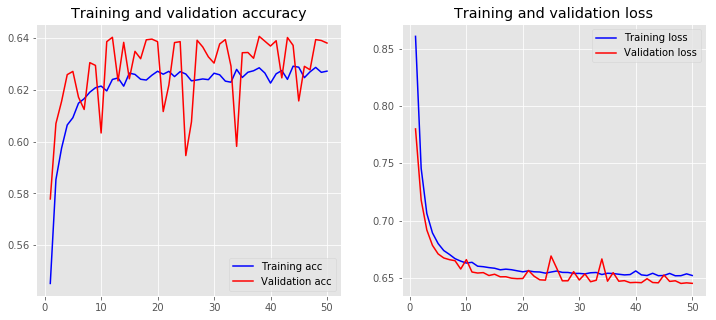

In [63]:
plot_history(history_noembedtrain)

In [64]:
model_embed_train = keras.Sequential([
keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
keras.layers.GlobalMaxPool1D(),
keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model_embed_train.summary()
model_embed_train.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_embedtrain = model_embed_train.fit(X_train, y_train, 
          epochs=50,
          batch_size=256, 
          validation_split=0.3, 
          verbose=1,
          callbacks=[early_stop])
scores = model_embed_train.evaluate(X_test, y_test, verbose=1)
print(model_embed_train.metrics_names, scores)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 256, 100)          5962800   
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 5,964,433
Trainable params: 5,964,433
Non-trainable params: 0
_________________________________________________________________
Train on 26250 samples, validate on 11250 samples
Epoch 1/50
26112/26250 [============================>.] - ETA: 0s - loss: 0.8875 - acc: 0.5645

KeyboardInterrupt: 

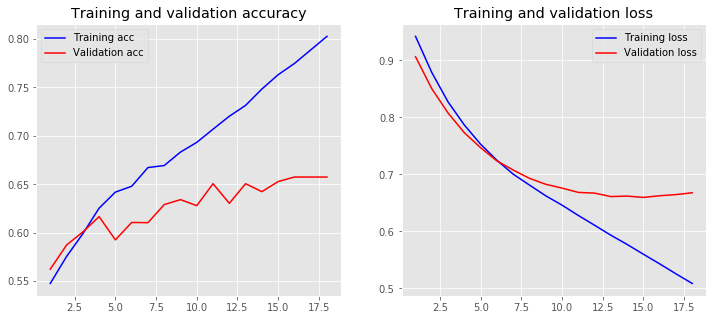

In [62]:
plot_history(history_embedtrain)